In [1]:
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from PIL import Image

In [2]:
DATASET_ROOT = '/home/jakub/code/covid-19/data'
DATASET_TRAIN = DATASET_ROOT + '/train'
DATASET_TEST = DATASET_ROOT + '/test'

In [3]:
image_path = DATASET_TRAIN + '/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg'
image_path

'/home/jakub/code/covid-19/data/train/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg'

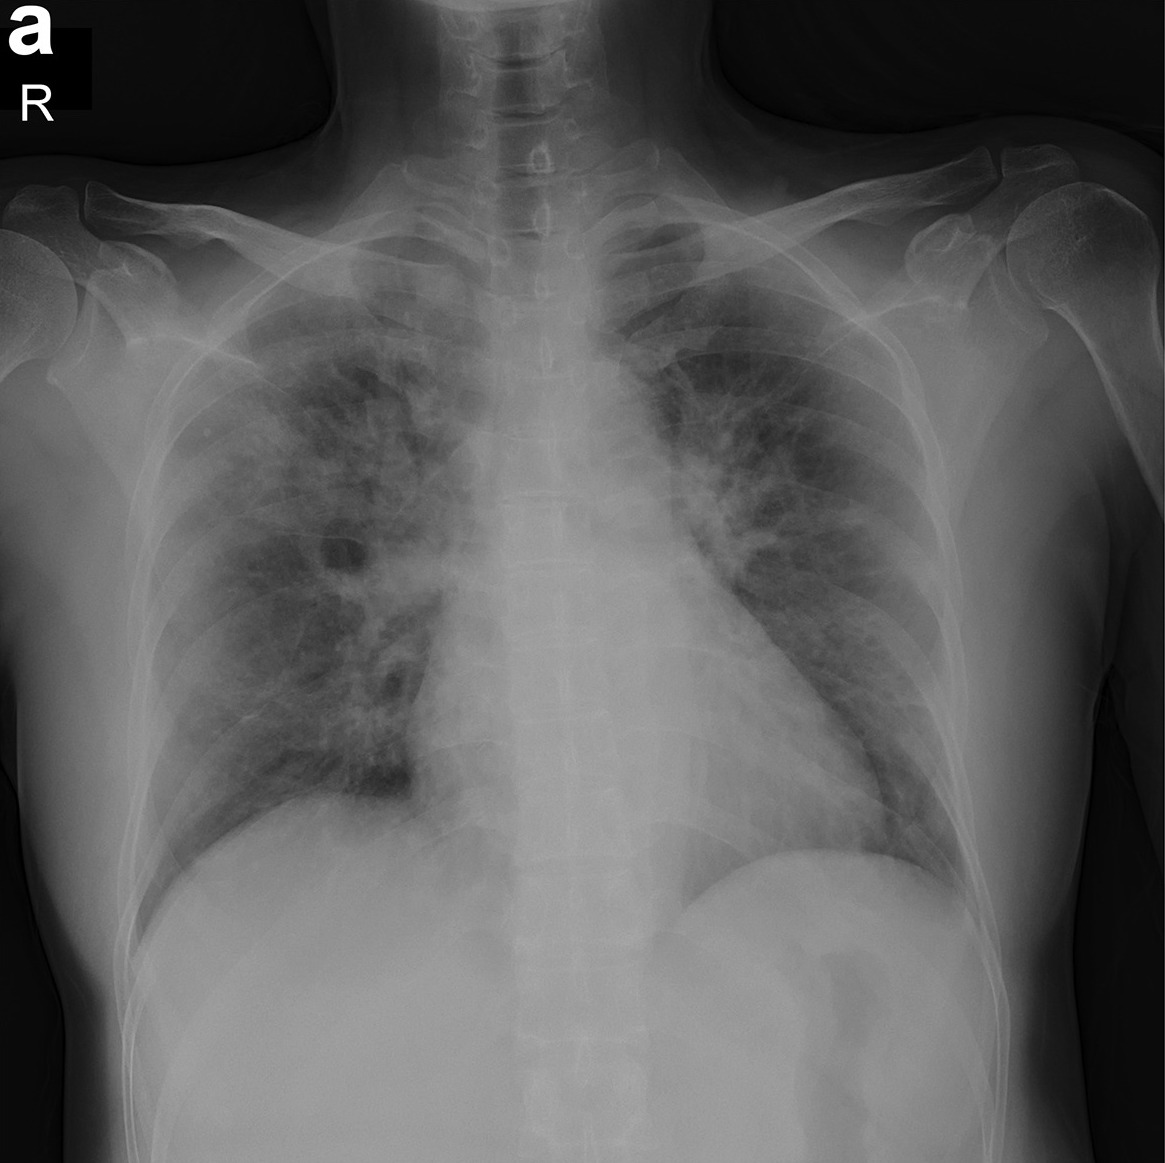

In [4]:
image = Image.open(image_path)
image

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 4

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        DATASET_TRAIN,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        DATASET_TEST,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary',
        shuffle=False)

Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

baseModel = ResNet50(weights="imagenet", include_top=False,
input_tensor=Input(shape=(150, 150, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [51]:


model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=1)
model.save_weights('first_try.h5')  # always save your weights after training or during training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 1 steps
Epoch 1/15
10/10 [==============================] - 5s 485ms/step - loss: 1.0962 - accuracy: 0.6000 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 2/15
10/10 [==============================] - 2s 198ms/step - loss: 0.6039 - accuracy: 0.7500 - val_loss: 0.6948 - val_accuracy: 0.6000
Epoch 3/15
10/10 [==============================] - 2s 200ms/step - loss: 0.1958 - accuracy: 0.9500 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 4/15
10/10 [==============================] - 2s 204ms/step - loss: 0.2880 - accuracy: 0.8500 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 5/15
10/10 [==============================] - 2s 196ms/step - loss: 0.3114 - accuracy: 0.8250 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 6/15
10/10 [==============================] - 2s 196ms/step - loss: 0.3759 - accuracy: 0.8000 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 7/15
10/10 [==============================] - 2s 20

KeyboardInterrupt: 

In [ ]:
validation_generator.class_indices

In [37]:
validation_generator.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [38]:
preds = model.predict(validation_generator)
preds

array([[0.51723063, 0.48276937],
       [0.4835902 , 0.51640975],
       [0.49063548, 0.5093644 ],
       [0.49946672, 0.5005333 ],
       [0.48103386, 0.51896614],
       [0.51271605, 0.48728392],
       [0.50554425, 0.4944558 ],
       [0.5292451 , 0.47075483],
       [0.50621045, 0.49378952],
       [0.4906513 , 0.5093487 ]], dtype=float32)

In [39]:
preds > 0.5

array([[ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True]])